## Task A

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import MDS
import re
import spacy
import spacy.cli
from spacy.lang.en import stop_words
spacy.cli.download("en_core_web_sm")

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
# Documents
doc = pd.read_csv('edmunds_extraction.csv')
doc['message'].fillna('', inplace=True)

In [3]:
# Clean Text
nlp = spacy.load('en_core_web_sm')
def clean_text(x): # x is a document
    # conver to lower case 
    x = x.lower()
    # remove new line
    x = re.sub(r'\n', ' ', x)
    # remove link
    x = re.sub(r"https?://[^\s]+", "", x)
    # remove name twitter tag
    x = re.sub(r'@[A-Za-z0-9\_]+', ' ', x) 
    # remove name hashtag tag
    x = re.sub(r'\#[A-Za-z0-9\_]+', ' ', x) 
    # remove specific word - southwest OR airline
    x = re.sub('southwest|airline', ' ', x)
    # lemmatization
    x = ' '.join([token.lemma_ for token in nlp(x)])
    # remove multiple space
    x = re.sub(r' +', ' ', x)
    # remove space before and after the text
    x = x.strip()
    return x

In [4]:
# Convert documents into a list
all_documents = doc['message'].tolist()

In [5]:
# List of non-brand words to exclude
exclude_words = ['problem', 'car', 'seat', 'engine', 'wheel', 'door', 'window', 'suv', 'sedan', 'vehicle', 'mpv', 'hatchback', 'crossover', 'convertible', 'coupe', 'truck', 'van', 'roadster', 'cabriolet', 'sportscar']

# Read the list of car brands/models from the CSV file
models = pd.read_csv('models.csv', header=None)

# Extract unique brand names as a list
car_brands = models[0].unique().tolist()

# Remove non-brand words from the list
car_brands = [brand for brand in car_brands if brand.lower() not in exclude_words]

In [6]:
# Initialize the CountVectorizer to transform the text data into a bag-of-words model only for the top 10 most frequent non-stopwords, do the MDS for those words
vectorizer = CountVectorizer(vocabulary=car_brands, # stopwords in NLTK is more complete than Sklearn, https://gist.github.com/sebleier/554280
                             max_features=10, # include only the top 10 words
                             preprocessor=clean_text,
                             token_pattern='[a-zA-Z0-9]{3,}') # include words with more than 3 characters 

In [7]:
# Transform the documents into a document-term matrix
dtm = vectorizer.fit_transform(all_documents)

# Extract feature names (non-stopwords)
feature_names = vectorizer.get_feature_names_out()

# Convert the document-term matrix to a dense array
dtm_array = dtm.toarray()

# Calculate lift between terms
term_lift = np.dot(dtm_array.T, dtm_array)
term_occurrence = np.sum(dtm_array, axis=0)

# Recheck for brands with zero occurrences and handle them
zero_occurrence_indices = np.where(term_occurrence == 0)[0]
if len(zero_occurrence_indices) > 0:
    for idx in zero_occurrence_indices:
        print(f"Brand '{feature_names[idx]}' is not mentioned and will be excluded from MDS analysis.")
    # Exclude brands with zero occurrences
    valid_indices = np.setdiff1d(np.arange(len(feature_names)), zero_occurrence_indices)
    dtm_array = dtm_array[:, valid_indices]
    term_lift = term_lift[valid_indices][:, valid_indices]
    term_occurrence = term_occurrence[valid_indices]
    feature_names = [feature_names[i] for i in valid_indices]

# Select indices of top 10 most frequent brands
top_10_indices = np.argsort(term_occurrence)[-10:]

# Filter DTM and feature names for top 10 brands
dtm_array = dtm.toarray()[:, top_10_indices]
feature_names = [feature_names[i] for i in top_10_indices]
    
# Add a small constant to avoid division by zero and calculate lift matrix
constant = 1e-8
lift_matrix = np.zeros((len(feature_names), len(feature_names)))
for i in range(len(feature_names)):
    for j in range(len(feature_names)):
        if term_occurrence[i] * term_occurrence[j] > 0:
            lift_matrix[i, j] = term_lift[i, j] / (term_occurrence[i] * term_occurrence[j] + constant)
        else:
            lift_matrix[i, j] = 0  # Set lift to 0 if either term does not occur

# Calculate dissimilarity matrix based on lift
dissimilarity_matrix = np.where(lift_matrix != 0, 1 / lift_matrix, 0)
print(dissimilarity_matrix)

Brand 'hyndai kia' is not mentioned and will be excluded from MDS analysis.
Brand 'hyundai,' is not mentioned and will be excluded from MDS analysis.
Brand 'hyundai.' is not mentioned and will be excluded from MDS analysis.
Brand 'kia,' is not mentioned and will be excluded from MDS analysis.
Brand 'kia.' is not mentioned and will be excluded from MDS analysis.
Brand 'nissan.' is not mentioned and will be excluded from MDS analysis.
Brand 'toyata' is not mentioned and will be excluded from MDS analysis.
Brand 'volkwagen' is not mentioned and will be excluded from MDS analysis.
[[4.15254237e+01 0.00000000e+00 1.08500000e+03 2.95000000e+02
  0.00000000e+00 0.00000000e+00 5.46000000e+03 0.00000000e+00
  6.40000000e+03 9.10608696e+02]
 [0.00000000e+00 3.11538462e+01 5.07272727e+02 1.32750000e+03
  8.32500000e+02 0.00000000e+00 0.00000000e+00 3.73500000e+03
  8.22857143e+03 2.17161290e+03]
 [1.08500000e+03 5.07272727e+02 8.26666667e+01 8.12888889e+02
  1.14700000e+03 0.00000000e+00 9.672000

In [8]:
print("Top 10 brands by frecuency: ", feature_names)

Top 10 brands by frecuency:  ['subaru', 'saturn', 'bmw', 'chrysler', 'nissan', 'hyundai', 'mazda', 'toyota', 'ford', 'honda']


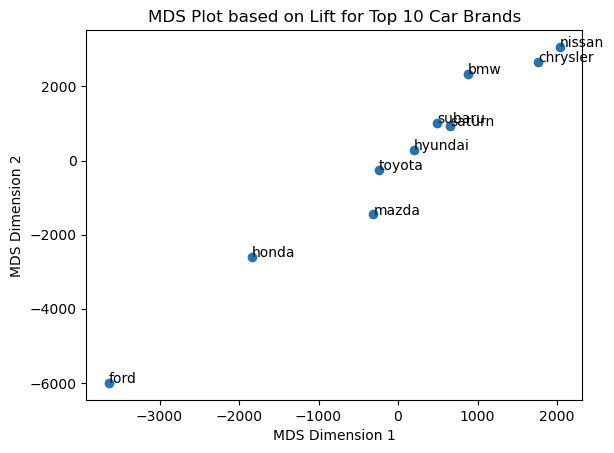

In [9]:
# Apply MDS to reduce dimensionality to 2D
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
mds_result = mds.fit_transform(dissimilarity_matrix)

# Plot the MDS result
plt.scatter(mds_result[:, 0], mds_result[:, 1])

# Annotate points with feature names
for i, txt in enumerate(feature_names):
    plt.annotate(txt, (mds_result[i, 0], mds_result[i, 1]))

plt.title('MDS Plot based on Lift for Top 10 Car Brands')
plt.xlabel('MDS Dimension 1')
plt.ylabel('MDS Dimension 2')
plt.show()

## Task B

### Ford:

Positioning: Ford appears quite distant from all other brands on the plot, particularly on the MDS Dimension 1 axis. This could indicate that Ford is discussed in contexts that are very different from the other brands, possibly due to unique features, market positioning, or customer base.

Differentiation: The substantial separation along the horizontal axis suggests that Ford's brand or products may be unique in the eyes of customers or are mentioned in unique scenarios. This can be a strength if the uniqueness is due to positive attributes like affordability, reliability, or specific features that are valued by customers.

Targeted Marketing Strategies: Given Ford's positioning on the plot, brand managers might consider emphasizing the unique attributes that set Ford apart in marketing campaigns. If the discussion indicates positive unique attributes, these should be highlighted. If negative, strategies to address these perceptions should be developed.


### BMW:

Brand Association: BMW is positioned close to Nissan and Chrysler, which might indicate that these brands share some commonalities in how customers discuss them. This could be due to similar customer demographics, marketing strategies, or shared product features.

Premium Market Perception: Being a premium brand, BMW's proximity to other non-luxury brands could be a concern if the brand wishes to maintain a distinct premium image. Brand managers might want to investigate the context in which BMW is discussed alongside these other brands to ensure that its premium branding is not being diluted.

Strategic Brand Partnerships: The closeness to other brands may also suggest opportunities for strategic partnerships or co-branding initiatives, especially if the shared attributes are positive.



#### For both brands, the insights from the MDS plot should be combined with qualitative data to understand the context behind the brand associations. Brand managers should look into the specific content of the conversations to see what attributes or topics are driving the associations. This could inform product development, marketing campaigns, and customer engagement strategies to reinforce or adjust the brand's position in consumers' minds.